# QUBO formulation of polynomial equation

# Use case

To illustrate the metohod we are taking the equation of the two node water system that reads:

$$
 0.5 - x_0 + x_1 = 0 \\
 1 - x_1 = 0 \\
 2 - q x_0^2 - x_2 = 0 \\
 -p x_1^2 + x_2 - x_3 = 0 
$$

with $q$ and $p$ paramerers taking disrete values either 1 or 2

In [1]:
import numpy as np

def nlfunc(input):
    x0,x1,x2,x3 = input
    q, p = parameters

    def f0():
        return 0.5 - x0 + x1
    
    def f1():
        return 1 - x1
    
    def f2():
        return 2  - q*x0**2  - x2

    def f3():
        return -p*x1**2 + x2 - x3
    
    return np.array([f0(), f1(), f2(), f3()])



## 2. QUBO formalism for linear systems

The Quandratic Unconstrainted Binary Optimization problem, or QUBO, allows to minimize the cost function :

$$
E(x) = x^{T}Qx
$$

where the variables $x_i$ are binaries, i.e. the are 0 or 1. The equation above can be rewritten as :

$$
E(x) = \sum_i Q_{ii}x_i + \sum_{ij} Q_{ij}x_ix_j
$$

that is very similar to the Ising model, basis of the quantum annealler architecture. 

### Encoding real numbers in binary variables

In the QUBO problems, variables are binaries and we of course want to solve for real numbers in our case. There ar e different ways to encode real numbers in multiple binaries. In our case since the variables are between -1.0 and 1.0 we can use the following encoding : 

$$
r_i = a \sum_n x_n 2^{n} - x_{k+n} 2^{n} 
$$

where $a$ is a normalization constant. THis encoding is created in the `SolutionVector` class that allows to encode/decode real numbers in a series of binaries variables. We use here the `RealUnitQbitEncoding` to obtain real numbers between -1 and 1. The number of qbit controls the precision of the reals we can obtain.

### Polynomial equation

We first write the polynomial equation as follow (https://www.nature.com/articles/s41598-019-46729-0) 

$$
F(X) = 0
$$

with

$$
F_i = P_i^{(0)} + \sum_j P_{ij}^{(1)}x_j + \sum_{jk} P_{ijk}^{(2)}x_j x_k  = 0
$$

To solve the system we minimize the residual sum of square

$$
\chi^2 = [P^{(0)} + P^{(1)} X + P^{(2)} X X.T ]^2
$$


# Use case

To illustrate the metohod we are taking the equation of the two node water system that reads:

$$
 0.5 - x_0 + x_1 = 0 \\
 1 - x_1 = 0 \\
 2 - q x_0^2 - x_2 = 0 \\
 -p x_1^2 + x_2 - x_3 = 0 \\
 c( M - q - p) \rightarrow 0 
$$

## 3. Solving the system

We will use here the `SimulatedAnnealingSampler` to be able to run that code locally. Quantum solvers are available through the Leap cloud service.

In [2]:
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
from qubols.mixed_solution_vector import MixedSolutionVector_V2 as MixedSolutionVector
from qubols.encodings import PositiveQbitEncoding, DiscreteValuesEncoding, RangedEfficientEncoding
import numpy as np 


vals = np.array([0.0559702820337183,
 0.207808449766538,
 0.23298897621448805,
 0.38482714394730777])

# vals = np.array([0.025376709013691795,
#  0.07395128696628388,
#  0.13854430584226343,
#  0.18711888379485553])

# vals = np.array([0.25, 0.5])

sol_vec0 = SolutionVector(size=4, encoding=RangedEfficientEncoding(nqbit=6, range=2, offset=0, var_base_name="x"))
sol_vec1 = SolutionVector(size=2, encoding=DiscreteValuesEncoding(vals, 2, "x"))


msv = MixedSolutionVector([sol_vec0, sol_vec1])

/home/nico/QuantumApplicationLab/qubols/qubols/encodings.py:264: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs, res, rank, s = np.linalg.lstsq(A, self.discrete_values)


In [3]:
sol_vec1.encoded_reals[0].get_possible_values()

[0.05597028203371821,
 0.20780844976653792,
 0.23298897621448816,
 0.3848271439473079]

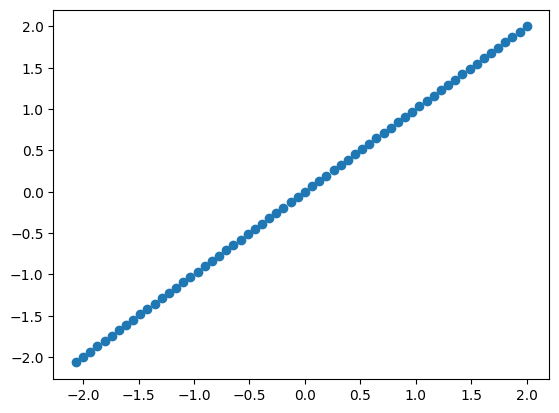

In [4]:
val = sol_vec0.encoded_reals[0].get_possible_values()
import matplotlib.pyplot as plt 
plt.scatter(val, val)

# Classical solution 
Enueration of the possible values using Newton Raphson

In [5]:
from quantum_newton_raphson.newton_raphson import newton_raphson
import itertools

values = sol_vec1.encoded_reals[0].get_possible_values()
parameters_list = itertools.product(values, repeat=2)

for parameters in parameters_list:
    initial_point = np.random.rand(4)
    res = newton_raphson(nlfunc, initial_point)
    assert np.allclose(nlfunc(res.solution), 0)
    print(parameters, res.solution)

(0.05597028203371821, 0.05597028203371821) [1.5        1.         1.87406687 1.81809658]
(0.05597028203371821, 0.20780844976653792) [1.5        1.         1.87406687 1.66625842]
(0.05597028203371821, 0.23298897621448816) [1.5        1.         1.87406687 1.64107789]
(0.05597028203371821, 0.3848271439473079) [1.5        1.         1.87406687 1.48923972]
(0.20780844976653792, 0.05597028203371821) [1.5        1.         1.53243099 1.47646071]
(0.20780844976653792, 0.20780844976653792) [1.5        1.         1.53243099 1.32462254]
(0.20780844976653792, 0.23298897621448816) [1.5        1.         1.53243099 1.29944201]
(0.20780844976653792, 0.3848271439473079) [1.5        1.         1.53243099 1.14760384]
(0.23298897621448816, 0.05597028203371821) [1.5        1.         1.4757748  1.41980452]
(0.23298897621448816, 0.20780844976653792) [1.5        1.         1.4757748  1.26796635]
(0.23298897621448816, 0.23298897621448816) [1.5        1.         1.4757748  1.24278583]
(0.23298897621448816, 0

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


# Quantum SOolution

In [6]:
import numpy as np
import sparse
def define_matrices():
    
    # system of equations
    num_equations = 5
    num_variables = 6
    c = 1E-1
    M = 2*sol_vec1.encoded_reals[0].get_max_value()

    P0 = np.zeros((num_equations,1))
    P0[0] = 1/2
    P0[1] = 1
    P0[2] = 2
    P0[3] = 0
    P0[4] = c*M

    P1 = np.zeros((num_equations, num_variables))
    P1[0, 0] = -1
    P1[0, 1] =  1

    P1[1, 1] = -1

    P1[2, 2] = -1

    P1[3, 2] =  1 
    P1[3, 3] = -1

    # cost
    P1[4,4] = -c
    P1[4,5] = -c
   

    P2 = np.zeros((num_equations, num_variables, num_variables))


    P3 = np.zeros((num_equations, num_variables, num_variables, num_variables))
    P3[2, 0, 0, 4] = -1
    P3[3, 1, 1, 5] = -1


    return sparse.COO(P0), sparse.COO(P1), sparse.COO(P2), sparse.COO(P3)

matrices = define_matrices()

In [7]:
from qubols.qubo_poly_mixed_variables import QUBO_POLY_MIXED 
qubo = QUBO_POLY_MIXED(msv)

In [8]:
# create the bqm
bqm = qubo.create_bqm(matrices, strength=1000)

# add constraint
slacks2 = bqm.add_linear_inequality_constraint(qubo.all_expr[3], lagrange_multiplier=1, label="head2", lb=1, ub=2)
slacks1 = bqm.add_linear_inequality_constraint(qubo.all_expr[2], lagrange_multiplier=1, label="head1", lb=1, ub=2)

# sample
sampleset = qubo.sample_bqm(bqm, num_reads=100000)

# decode
sol, param = qubo.decode_solution(sampleset.lowest())
print(sol, param)

/home/nico/miniconda3/envs/vitens_wntr_1/lib/python3.9/site-packages/dimod/binary/binary_quadratic_model.py:759: UserWarning: For constraints with fractional coefficients, multiply both sides of the inequality by an appropriate factor of ten to attain or approximate integer coefficients. 
  warnings.warn("For constraints with fractional coefficients, "


[1.6129032258064515, 1.032258064516129, 0.967741935483871, 0.967741935483871] [0.3848271439473079, 0.05597028203371821]


In [9]:
parameters = param
nlfunc(sol)

array([-0.08064516, -0.03225806,  0.03114687, -0.05963951])